# Training small CNN on 23-714262 subset of sickle cell dataset

20-06-2024

Here, I implement a small CNN with less than 20 layers to gauge its performance on the subset of the Cytopix dataset of about 1000 cells. 
The subset was labelled by me and checked by Erik Mul and Martijn Veldthuis from Central Facility and Diagnostics of Sanquin, respectively. 

In [2]:
import cv2
import json
import os
import sklearn

import numpy as np
import pandas as pd

from functools import partial

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)
keras.backend.clear_session()
from keras.callbacks import LearningRateScheduler

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

2024-06-27 09:52:55.548204: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 09:52:57.016490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 09:53:07.673755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

## Import custom functions

In [ ]:
def get_confusion_matrix(y_pred, y_test):

    fig, ax = plt.subplots(figsize=(8, 8))

    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

## Import data


In [ ]:
f = open(
    "/home/t.afanasyeva/deep_learning_anaemias/resources/annotations/240627_23-714262.json"
)
annotations = json.load(f)
annotations["categories"]

[{'id': 1, 'name': 'discocyte', 'supercategory': ''},
 {'id': 2, 'name': 'holly_leaf', 'supercategory': ''},
 {'id': 3, 'name': 'granular', 'supercategory': ''},
 {'id': 4, 'name': 'sickle', 'supercategory': ''},
 {'id': 5, 'name': 'echinocyte', 'supercategory': ''}]

Only entries up to 1000 have been checked by Erik and Martijn. These annotations were done using CVAT. Labels need to be extracted from JSON file.

In [ ]:
ground_truth = annotations["annotations"][:1000]
ground_truth[:1][0]

{'id': 1,
 'image_id': 1,
 'category_id': 1,
 'segmentation': [],
 'area': 811.2000000000003,
 'bbox': [20.7, 16.4, 24.0, 33.8],
 'iscrowd': 0,
 'attributes': {'occluded': False, 'rotation': 0.0}}

In [ ]:
image_ids = [record["image_id"] for record in ground_truth]
labels_tuples = [(record["image_id"], record["category_id"]) for record in ground_truth]
images = annotations["images"]
file_names_tuples = [
    (record["id"], record["file_name"])
    for record in images
    if record["id"] in image_ids
]
file_name_labels_dict = {}
for file_name in file_names_tuples:
    for label in labels_tuples:
        if file_name[0] == label[0]:
            file_name_labels_dict[file_name[1]] = label[1]

annotations["categories"]

[{'id': 1, 'name': 'discocyte', 'supercategory': ''},
 {'id': 2, 'name': 'holly_leaf', 'supercategory': ''},
 {'id': 3, 'name': 'granular', 'supercategory': ''},
 {'id': 4, 'name': 'sickle', 'supercategory': ''},
 {'id': 5, 'name': 'echinocyte', 'supercategory': ''}]

In [ ]:
maping_list = [(record["id"], record["name"]) for record in annotations["categories"]]

for key, value in file_name_labels_dict.items():
    for my_tuple in maping_list:
        if value == my_tuple[0]:
            file_name_labels_dict[key] = my_tuple[1]

[(1, 'discocyte'),
 (2, 'holly_leaf'),
 (3, 'granular'),
 (4, 'sickle'),
 (5, 'echinocyte')]

In [ ]:
label_df = pd.DataFrame.from_dict(
    file_name_labels_dict, orient="index", columns=["class"]
)
label_df

,class
0000198e5271d6317b88554bb42519a3.png,discocyte
000040960984c457d2da9089d736faad.png,echinocyte
0006362b11698a3f9180de79cb73c8bc.png,discocyte
000910fe21195b6011df32d34ad36768.png,sickle
000edf251c8ead45d3c5b8f389333123.png,granular
...,...
3813fb9f8afcd6b019ffdd4261e3d234.png,echinocyte
381c16064300d74bc052555351306dfe.png,discocyte
382ba271f517a5dcdbb59fc0ff1d3355.png,sickle
384908eaa2d399d452d92d5638676605.png,discocyte


In [ ]:
y = label_df["class"]
y.shape

(1000,)

<Axes: >

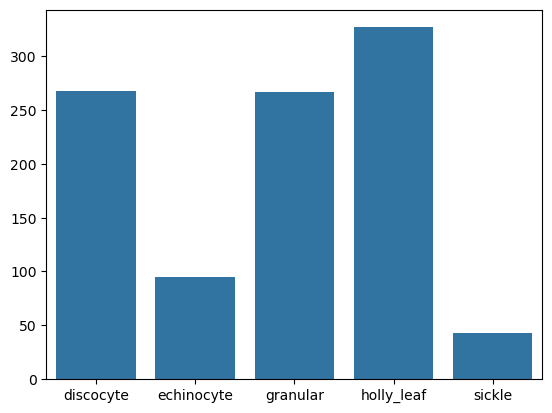

In [45]:
unique, counts = np.unique(y, return_counts=True)
sns.barplot(y=counts, x=unique)

In [ ]:
path = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262"
X = []
for img_path in list(label_df.index):
    img = cv2.imread(os.path.join(path, img_path), cv2.IMREAD_GRAYSCALE)
    X.append(img)
X = np.expand_dims(X, axis=-1).astype(np.float32) / 255
X.shape

(1000, 64, 64, 1)

In [ ]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)
y_val = y[:200]
y = y[200:]
X_val = X[:200]
X = X[200:]

le = LabelEncoder()
y = le.fit_transform(y)
X.shape, y.shape

## Make model

In [27]:
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)

cnn_model = tf.keras.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, input_shape=[64, 64, 1]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=5, activation="softmax"),
    ]
)

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-06-27 09:53:23.618470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [ ]:
cnn_model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,215,749 (12.27 MB)

 Trainable params: 3,215,749 (12.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)


BATCH_SIZE = 32
EPOCHES = 20
CV = 3

skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=93)
earlystopper = keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, verbose=0, mode="min", restore_best_weights=True
)
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

## Train model

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2751 - auc: 0.6273 - loss: 1.6456 - val_accuracy: 0.2659 - val_auc: 0.6723 - val_loss: 1.5975
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3797 - auc: 0.7072 - loss: 1.5327 - val_accuracy: 0.2659 - val_auc: 0.6723 - val_loss: 1.5983
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5793 - auc: 0.8453 - loss: 1.0955 - val_accuracy: 0.2659 - val_auc: 0.6465 - val_loss: 1.5951
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7846 - auc: 0.9579 - loss: 0.5683 - val_accuracy: 0.2659 - val_auc: 0.6639 - val_loss: 1.5882
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7353 - auc: 0.9374 - loss: 0.7303 - val_accuracy: 0.2659 - val_auc: 0.6695 - val_loss: 1.5829
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7594 - auc: 0.9426 - loss: 0.6645 - val_accuracy: 0.2659 - val_auc: 0.6465 - val_loss: 1.5789
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/s

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6362 - auc: 0.8485 - loss: 1.7091 - val_accuracy: 0.2659 - val_auc: 0.6011 - val_loss: 1.5461
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6545 - auc: 0.8934 - loss: 0.9466 - val_accuracy: 0.2659 - val_auc: 0.5627 - val_loss: 1.5751
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9249 - auc: 0.9891 - loss: 0.3167 - val_accuracy: 0.2659 - val_auc: 0.5627 - val_loss: 1.6227
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9887 - auc: 0.9997 - loss: 0.0724 - val_accuracy: 0.2659 - val_auc: 0.5627 - val_loss: 1.6708
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9782 - auc: 0.9988 - loss: 0.0851 - val_accuracy: 0.2659 - val_auc: 0.5627 - val_loss: 1.6746
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9421 - auc: 0.9956 - loss: 0.1669 - val_accuracy: 0.2659 - val_auc: 0.5627 - val_loss: 1.6991
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accu

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 905ms/step - accuracy: 0.5759 - auc: 0.8696 - loss: 1.0078 - val_accuracy: 0.2707 - val_auc: 0.5677 - val_loss: 1.5462
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8126 - auc: 0.9681 - loss: 0.4995 - val_accuracy: 0.2707 - val_auc: 0.5963 - val_loss: 1.5471
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9329 - auc: 0.9960 - loss: 0.1781 - val_accuracy: 0.2707 - val_auc: 0.6250 - val_loss: 1.5550
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9676 - auc: 0.9967 - loss: 0.1163 - val_accuracy: 0.2707 - val_auc: 0.6250 - val_loss: 1.5359
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9012 - auc: 0.9904 - loss: 0.2805 - val_accuracy: 0.2707 - val_auc: 0.6250 - val_loss: 1.5262
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8607 - auc: 0.9786 - loss: 0.3926 - val_accuracy: 0.2707 - val_auc: 0.6250 - val_loss: 1.5280
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - ac

/home/t.afanasyeva/miniforge3/envs/IMG/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


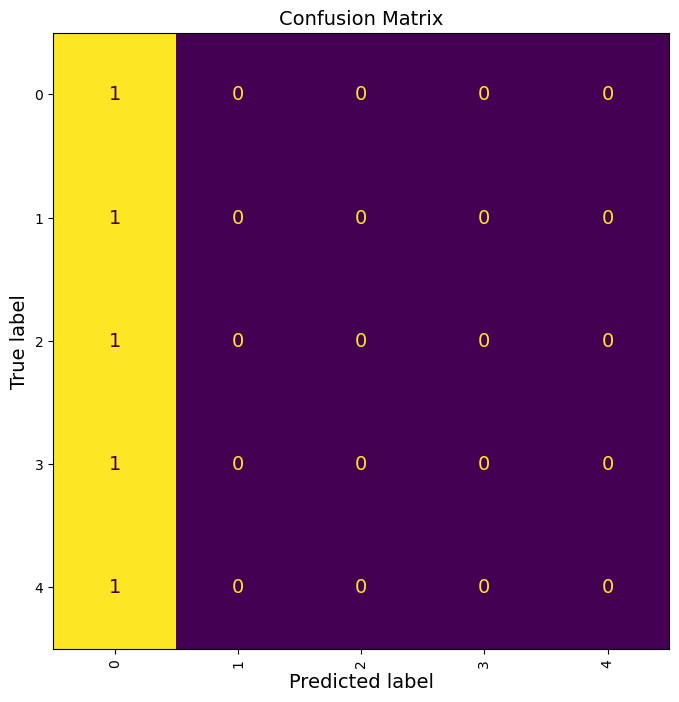

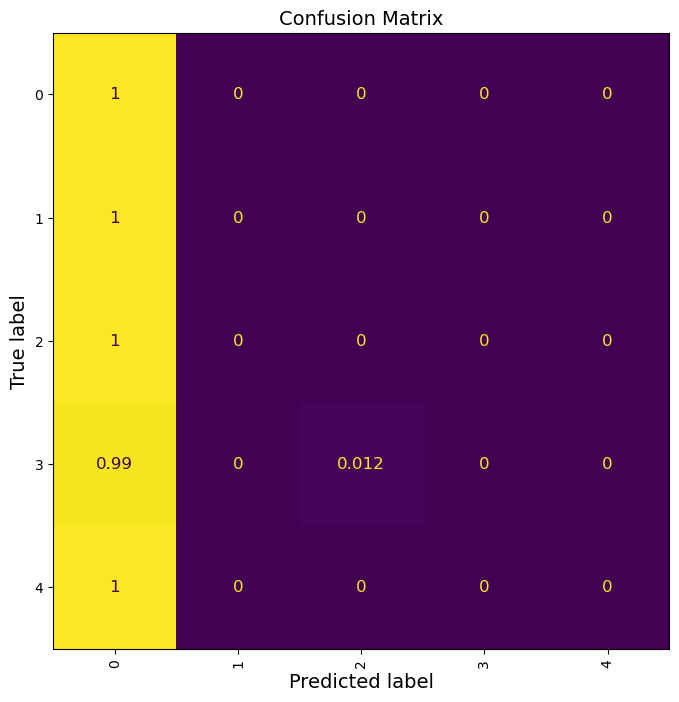

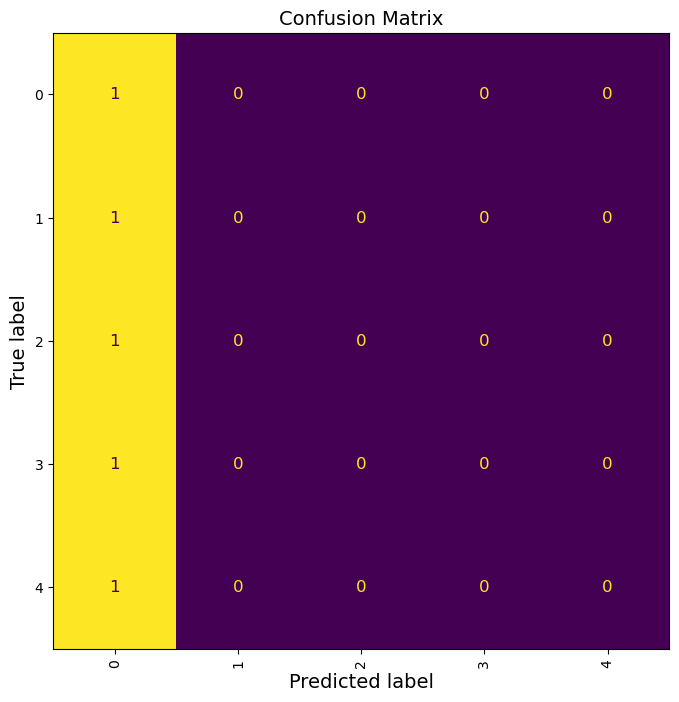

In [ ]:
predictions = []

for train_index, test_index in skf.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    y_test_c = to_categorical(y_test)
    y_train_c = to_categorical(y_train)

    history = mobile_net.fit(
        X_train,
        y_train_c,
        batch_size=BATCH_SIZE,
        epochs=EPOCHES,
        callbacks=[earlystopper],
        validation_data=(X_test, y_test_c),
    )

    y_pred = cnn_model.predict(X_test)
    y_pred = y_pred.argmax(axis=1)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    f1_score_model = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    scores = {
        "test_balanced_accuracy": accuracy,
        "test_f1_weighted": f1_score_model,
        "test_precision_weighted": precision,
    }

    scores_df = pd.DataFrame(scores, index=[0])
    print(scores_df)

    get_confusion_matrix(y_pred, y_test)

In [87]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

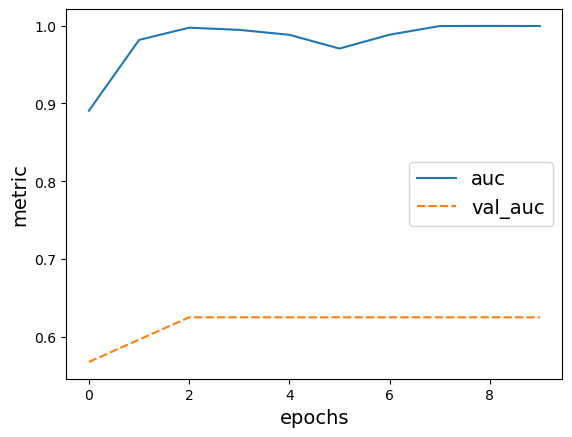

In [88]:
plot_history(history, ["auc", "val_auc"])

In [ ]:
history_df = pd.DataFrame.from_dict(history.history)
history_df

,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0.632959,0.890579,0.921858,0.270677,0.567669,1.546207
1,0.861423,0.981510,0.381972,0.270677,0.596335,1.547058
2,0.947566,0.997262,0.141825,0.270677,0.625000,1.554978
3,0.953184,0.994450,0.161462,0.270677,0.625000,1.535927
4,0.887640,0.988100,0.304944,0.270677,0.625000,1.526178
5,0.838951,0.970413,0.480544,0.270677,0.625000,1.527957
6,0.874532,0.988259,0.302024,0.270677,0.625000,1.526104
7,0.970037,0.999349,0.079827,0.270677,0.625000,1.558305
8,0.983146,0.999524,0.049719,0.270677,0.625000,1.554972
9,0.986891,0.999403,0.058287,0.270677,0.625000,1.578449


The model seems to be too small and does not learn well on the test set. 

dtype: uint8, shape: (120, 120, 3), min: 0, max: 3


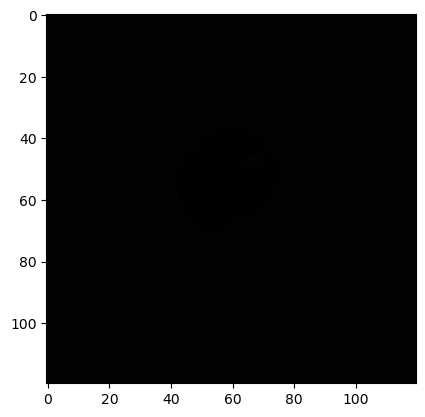

In [ ]:
path = "/home/t.afanasyeva/research_storage/Processing/Lab - Van Dam/datasets/srf_anaemias/CytPix/raw/24-Ramos-4122/12.tif"

# img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # for 23-714262 patient sample
img = cv2.imread(path)
assert img is not None, "file could not be read, check with os.path.exists()"

print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, "gray")